In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

2023-03-06 23:35:06.645952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 23:35:07.072858: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-06 23:35:07.945152: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-06 23:35:07.945326: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("test.csv")
candidate_sentences.shape

(23, 1)

In [29]:
doc = nlp("The human brain is a complex organ that controls all of the body's functions")

In [30]:
for x in doc:
    print(x.text, "...", x.dep_)

The ... det
human ... amod
brain ... nsubj
is ... ROOT
a ... det
complex ... amod
organ ... attr
that ... nsubj
controls ... relcl
all ... dobj
of ... prep
the ... det
body ... poss
's ... case
functions ... pobj


In [3]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [4]:
entity_pairs = []

for i in tqdm(candidate_sentences["Sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 23/23 [00:00<00:00, 125.03it/s]


In [5]:
entity_pairs

[['complex  that', 'functions'],
 ['It', 'frontal  lobe'],
 ['Each', 'such motor control'],
 ['also  which', 'synapses'],
 ['Neurotransmitters', 'mental health conditions'],
 ['Understanding', 'neurological  disorders'],
 ['100  Thieves', '2018 Cleveland Cavaliers organization'],
 ['American Scott that', '2014  February'],
 ['100th  MDB', 'Army Space Defense Command'],
 ['100th Missile Defense Brigade', 'component Air Force Base'],
 ['100th York Volunteer Infantry', 'American Civil War'],
 ['Thousand  Poets', 'educational  arts'],
 ['100th  Regiment', 'also British 1763'],
 ['100th  Regiment', 'Napoleonic Wars'],
 ['100  Thieves', 'late ex 2017'],
 ['', 'pounding  movies'],
 ['Aviation Regiment Military Number', '45782 Soviet Navy'],
 ['100th  Window', '1  UK'],
 ['100  Times', 'so Fat Wreck 1999'],
 ['300  sets', 'annum'],
 ['100 Ton Chicken', 'third Chicken 1969'],
 ['', 'single Recording Industry America'],
 ['100 Tourist Sites', 'natural  landmarks']]

In [6]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)
  print(matcher)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [7]:
get_relation("Monty and John hit the task")

'hit'

In [8]:
relations = [get_relation(i) for i in tqdm(candidate_sentences["Sentence"])]


100%|██████████| 23/23 [00:00<00:00, 137.58it/s]

In [9]:
pd.Series(relations).value_counts()[:50]

is                      8
was                     3
divided into several    1
is responsible          1
composed of             1
play                    1
is crucial              1
fielded                 1
raised in               1
expanded into           1
Thrills                 1
released in             1
manufactured per        1
Platinum by             1
dtype: int64

In [10]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [11]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

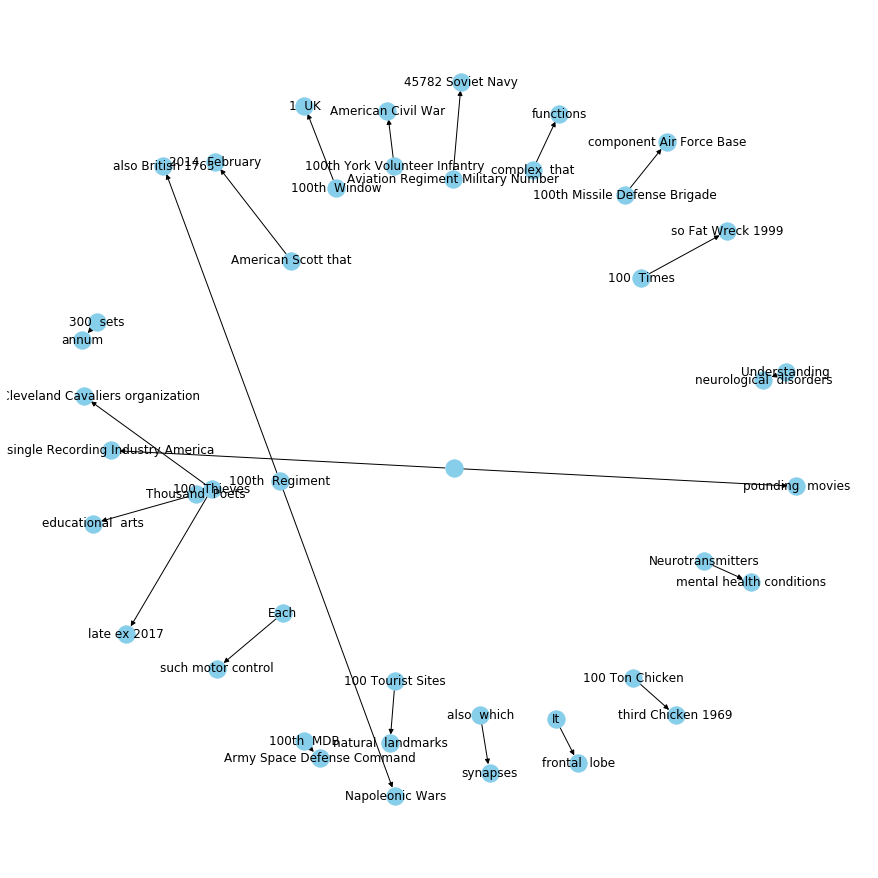

In [12]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()